# Interactive notebook on how to build and examine neurodynamic models in PyRates: 

## Setting up a Jansen-Rit-like cortical microcircuit using the Montbrio population model

In this example, it is your task to use PyRates to build a new model of a cortical microcircuit, fusing the architecture of the Jansen-Rit model and the evolution equations for the population dynamics proposed by Montbrió et al. (2015, Phys Rev X). 

Montbrio and colleagues derived a set of two coupled ODEs describing the dynamics of the average firing rate $r$ and membrane potential $v$ of a population of globally coupled quadratic integrate-and-fire neurons. The evolution equations for an excitatory QIF population are given by:

$$\tau \dot r = \frac{\Delta}{\pi\tau} +2 r v$$
$$\tau \dot v = v^2 +\eta + I_{ext}(t) + (Jr+r_{exc}-r_{inh}) \tau - (\pi r \tau)^2$$

With $\tau$ being the evolution time constant,  $J$ is the global coupling strength, $I_{ext}$ is external current and $\eta$ and $\Delta$ are the average and FWHM of the background input, respectively. We added $r_{exc}$ and $r_{inh}$ as placeholders for input from other excitatory or inhibitory populations that we may add later on. In the standard equations by Montbrió and colleagues, these variables are equal to 0.

The Jansen-Rit architecture is characterized by the following features:
- 3 interconnected populations: Pyramidal cells, excitatory interneurons and inhibitory interneurons
- Synaptic dynamics are expressed by convolutions with alpha kernels, describing an exponential rise and decay of the synaptic response

The benefit of a QIF-based cortical microcircuit is that neural refractoriness is represented in the single cell model and not lost by the mean-field reduction of Montbrio and colleagues. This leads to more realistic synchronization behavior within populations and allows for an explicit description of the amount of synchrony within a population. Given the extensive use of neural population models to investigate neural synchronization behavior in macroscopic neural networks (i.e. connectome models), this improvement could allow to capture a number of features of neural synchronization dynamics that could not be explained by models like the Jansen-Rit model that provide no direct description of the level of neural synchronization.

So lets start setting up the model.

## Step I: Implementing the Montbrio population dynamics in PyRates

### I.a setting of the operator templates

Your first task is to set up the operators implementing the equations from above. Thereby, you should distinguish between operators for excitatory and inhibitory populations, since we need both of them in the final model. In the cell below, we already provided some of the code required to do this. You just have to fill in the blank spots, marked by `...`.

In [1]:
import numpy as np
from pyrates.frontend import OperatorTemplate

# TODO: implement your solution below
#####################################

# equations for excitatory population
exc = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) /tau',
       'd/dt * v = (v^2 + eta + I_ext + (J*r+r_exc-r_inh)*tau - (PI*r*tau)^2) /tau']

# equations for inhibitory population
inh = ['d/dt * r = (delta/(PI*tau) + 2.*r*v) / tau',
       'd/dt * v = (v^2 + eta + I_ext + (r_exc-r_inh-J*r)*tau - (PI*r*tau)^2) /tau']

# equation variables
variables = {'delta': {'default': 1.0},
             'tau': {'default': 1.0},
             'eta': {'default': -5.0},
             'J': {'default': 15.0},
             'r': {'default': 'output'},
             'v': {'default': 'variable'},
             'I_ext': {'default': 'input'},
             'r_exc': {'default': 'input'},
             'r_inh': {'default': 'input'}}

# operator setup
op_exc = OperatorTemplate(name='Op_exc', path=None, equations=exc, variables=variables)
op_inh = OperatorTemplate(name='Op_inh', path=None, equations=inh, variables=variables)

### I.b setting up the node and circuit templates

Your next task is to create a circuit with a single node representing an excitatory QIF population governed by the above defined excitatory population operator.

In [2]:
from pyrates.frontend import NodeTemplate, CircuitTemplate

# TODO: implement your solution below
#####################################

# set up the node template
node_exc_temp = NodeTemplate(name='Pop_exc', path=None, operators=[op_exc])

# set up the circuit template
pop_exc_temp = CircuitTemplate(name='EC', path=None, nodes={'Pop_exc': node_exc_temp})

# transform the circuit template into an intermediate representation
pop_exc_ir = pop_exc_temp.apply()

### I.c simulating the population dynamics

Now, let's test whether the circuit behaves as expected, by simulating its behavior given some transient input.

In [3]:
dt = 1e-3                                      # integration step size in s
dts = 1e-2                                     # variable storage sub-sampling step size in s
T = 42.                                        # total simulation time in s
inp = np.zeros((int(T/dt), 1))                 # external input to the population
inp[int(6./dt):int((T-12.)/dt)] = 3.

# TODO: implement you solution below
####################################

# set up the computation graph
model = pop_exc_ir.compile(dt=dt)

# perform a numerical simulation with input delivered to u and recordings of v and r
results, t = model.run(simulation_time=T, 
                       inputs={"Pop_exc/Op_exc/I_ext": inp},
                       outputs={"r": "Pop_exc/Op_exc/r", 
                                "v": "Pop_exc/Op_exc/v"},
                       sampling_step_size=dts, 
                       profile=True)

building the compute graph...
Preparing the simulation...
Running the simulation...
42.0s of backend behavior were simulated in 2.650822877883911 s given a simulation resolution of 0.001 s.


### I.d visualizing the simulation results

This simulation should procude output timeseries equivalent to those shown below. Execute the next cell to visualize your simulation results and see whether they look alike.

<img src="img/qif_exc.svg">

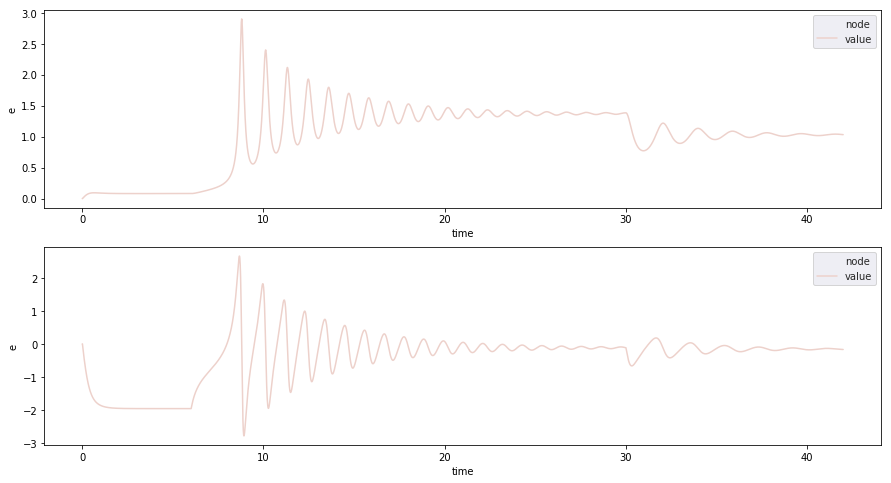

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pyrates.utility import plot_timeseries

fig, axes = plt.subplots(nrows=2, figsize=(15, 8))

# TODO: Implement your solution below
#####################################

# plot the firing rate in one axis
plot_timeseries(results['r'], ax=axes[0])

# plot the membrane potential in the other axis
plot_timeseries(results['v'], ax=axes[1])

## Step II: Creating a circuit of 3 interconnected QIF populations

Now that the operators are set up and tested, your task is to create 3 populations like the one above, connect them to a Jansen-Rit like circuit and choose their parameters such that they represent a pyramidal cell, excitatory interneuron and inhibitory interneuron population. The latter leaves some room for exploration/optimization. However, for now we would like the time-scale of the inhibitory population to be twice as long as the one of the excitatory populations. For setting up the connections, a reminder of the basic connectivity profile of the Jansen-Rit model can be found below.

<img src="img/JR_circuit_reduced.png">

### II.a defining the model

In [5]:
# TODO: implement your solution below
#####################################

# set up the population templates
pc_temp = NodeTemplate(name='PC', path=None, operators={op_exc: {'J': 0.0}})
ein_temp = NodeTemplate(name='EIN', path=None, operators={op_exc: {'J': 0.0, 'eta': -2.5}})
iin_temp = NodeTemplate(name='IIN', path=None, operators={op_inh: {'tau': 2.0, 'J': 0.0, 
                                                                   'eta': -2.5}})

# set up the circuit template
circuit_ir = CircuitTemplate(name='circuit', path=None,
                             nodes={'PC': pc_temp, 'EIN': ein_temp, 'IIN': iin_temp}
                            ).apply()

# add edges between the nodes
circuit_ir.add_edges_from([('PC/Op_exc/r', 'EIN/Op_exc/r_exc', {'weight': 13.5}),
                           ('EIN/Op_exc/r', 'PC/Op_exc/r_exc', {'weight': 1.8*13.5}),
                           ('PC/Op_exc/r', 'IIN/Op_inh/r_exc', {'weight': 0.25*13.5}),
                           ('IIN/Op_inh/r', 'PC/Op_exc/r_inh', {'weight': 1.75*13.5})])

# load the intermediate representation of the circuit into a compute graph
model = circuit_ir.compile(dt=dt)

building the compute graph...


### II.b simulating and visualizing the model dynamics

Now, lets simulate the behavior of the 3-population model. Feel free to play around with the parameters of the operators/edges in the cell above and see how it affects the model dynamics. To proceed, fill in the gaps in the cell below.

Preparing the simulation...
Running the simulation...
finished!


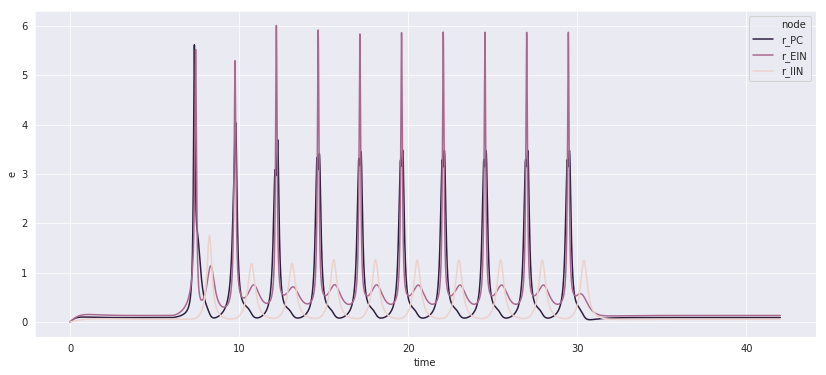

In [6]:
# TODO: implement your solution below
#####################################

# simulate the model behavior with input delivered to the PCs and recordings of all r's
results = model.run(simulation_time = T, 
                    outputs={'r_PC': 'PC/Op_exc/r', 
                             'r_EIN': 'EIN/Op_exc/r', 
                             'r_IIN': 'IIN/Op_inh/r'}, 
                    inputs={'PC/Op_exc/I_ext' : inp})

# END TODO: Below there is plotting
###################################

fig, axes = plt.subplots(figsize=(14, 6))
plot_timeseries(results, ax=axes)

## Step III: Adding synaptic dynamics to the circuit

To finalize the cortical microcircuit architecture, your task is to add a description of the synaptic response dynamics to each connection in the circuit. To this end, implement a simple, exponentially decaying model to each synapse type in the model (let's distinguish between excitatory and inhibitory synapses for now). The evolution equation of the synaptic current $I_{syn}$ is given by:

$$\dot{I_{syn}} = \sum_n r_n - \frac{I_{syn}}{\tau_{syn}}$$

with $\tau_{syn}$ being the time-scale of the synapse and the sum being defined over all incoming firing rates. This adds a secondary time-scale to the model, which we could choose according to some experimental measurements of AMPA or GABA dynamics, for example. However, to stick close to the original Jansen-Rit model, we set the synaptic time-scales equal to the membrane time constants, such that we have one fast excitatory and one slow inhibitory time-scale. 

### III.1 defining the model

Try to re-build the operators from Step I describing the population dynamics to include these synaptic dynamics.

In [7]:
# TODO: implement your solution below
#####################################

# define the equations for the excitatory populations
exc_syn = ['d/dt * r = (delta/(PI*tau) + 2.*r*v)/tau',
           'd/dt * v = (v^2 + eta + I_ext + (I_exc - I_inh)*tau - (PI*r*tau)^2)/tau',
           'd/dt * I_exc = J*r + r_exc - I_exc/tau_exc',
           'd/dt * I_inh = r_inh - I_inh/tau_inh']

# define the equations for the inhibitory population
inh_syn = ['d/dt * r = (delta/(PI*tau) + 2.*r*v)/tau',
           'd/dt * v = (v^2 + eta + I_ext + (I_exc - I_inh)*tau - (PI*r*tau)^2)/tau',
           'd/dt * I_exc = r_exc - I_exc/tau_exc',
           'd/dt * I_inh = J*r + r_inh - I_inh/tau_inh']

# define the equation variables
variables = {'delta': {'default': 1.0},
             'tau': {'default': 1.0},
             'eta': {'default': -2.5},
             'J': {'default': 0.0},
             'tau_exc': {'default': 1.0},
             'tau_inh': {'default': 2.0},
             'r': {'default': 'output'},
             'v': {'default': 'variable'},
             'I_ext': {'default': 'input'},
             'I_exc': {'default': 'variable'},
             'I_inh': {'default': 'variable'},
             'r_exc': {'default': 'input'},
             'r_inh': {'default': 'input'},
             }

# set up the operator templates for the excitatory and inhibitory operator
exc_syn_temp = OperatorTemplate(name='Op_exc_syn', path=None, equations=exc_syn, variables=variables)
inh_syn_temp = OperatorTemplate(name='Op_inh_syn', path=None, equations=inh_syn, variables=variables)

And now, let's rebuild the circuit from Step II based on the new operators.

In [8]:
from copy import deepcopy

# TODO: implement your solution below
#####################################

# set up the node templates with the respective operators
pc_syn_temp = NodeTemplate(name='PC', path=None, operators=[exc_syn_temp])
ein_syn_temp = NodeTemplate(name='EIN', path=None, operators={exc_syn_temp: {'eta': -0.5}})
iin_syn_temp = NodeTemplate(name='IIN', path=None, operators={inh_syn_temp: {'eta': -0.5, 'tau': 2.0}})

# set up a template of the 3 nodes and their edges
nodes = {'PC': pc_syn_temp, 'EIN': ein_syn_temp, 'IIN': iin_syn_temp}
edges = [('PC/Op_exc_syn/r', 'EIN/Op_exc_syn/r_exc', None, {'weight': 13.5}),
         ('EIN/Op_exc_syn/r', 'PC/Op_exc_syn/r_exc', None, {'weight': 0.8*13.5}),
         ('PC/Op_exc_syn/r', 'IIN/Op_inh_syn/r_exc', None, {'weight': 0.25*13.5}),
         ('IIN/Op_inh_syn/r', 'PC/Op_exc_syn/r_inh', None, {'weight': 1.75*13.5})]

circuit_temp = CircuitTemplate(name='EIC_syn_temp', path=None, nodes=nodes, edges=edges)
circuit_ir = deepcopy(circuit_temp).apply()

# transform the circuit template into an IR and load it into a compute graph
model = circuit_ir.compile(backend='numpy', dt=dt)

building the compute graph...


### III.b simulation and visualization

Again, let's test how the circuit behaves.

Preparing the simulation...
Running the simulation...
finished!


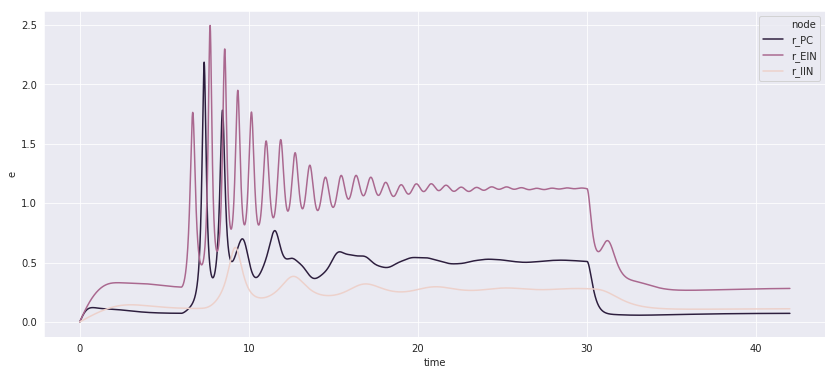

In [9]:
inp = np.zeros((int(T/dt), 1))
inp[int(6./dt):int((T-12.)/dt)] = 6.

# TODO: implement your solution below
#####################################

# perform a simulation with input delivered to the PCs and recordings of all r's
results = model.run(simulation_time = T, 
                    outputs={'r_PC': 'PC/Op_exc_syn/r', 
                             'r_EIN': 'EIN/Op_exc_syn/r', 
                             'r_IIN': 'IIN/Op_inh_syn/r'}, 
                    inputs={'PC/Op_exc_syn/I_ext': inp})

# END TODO: Below there is plotting
###################################

fig, axes = plt.subplots(figsize=(14, 6))
plot_timeseries(results, ax=axes)

## Step IV: Investigating the models parameter space

In a final step, your task is to perform some parameter sweeps to gain an intuition of how different parameters can affect the model dynamics. 

Below, you will find cells with 2 different parameter sweeps. 
One that examines how the model response changes when the strength of the self connections $J$ of each population are altered. Since all three $J$ are changed at the same rate, this is a 1D parameter sweep. 
The other one examines the dependence of the model dynamcis on the connection strengths of the couplings from excitatory and inhibitory population onto the pyramidal cells. Since the connection strengths are altered independently, this results in a 2D parameter sweep. 

Fill in the blanks to get them running.

### IV.a parameter sweep over $J$

building the compute graph...
EXPERIMENTAL FEATURE WARNING: Using the midpoint method for solving differential equations is not fully tested yet and should be used with caution.
Preparing the simulation...
Running the simulation...
finished!


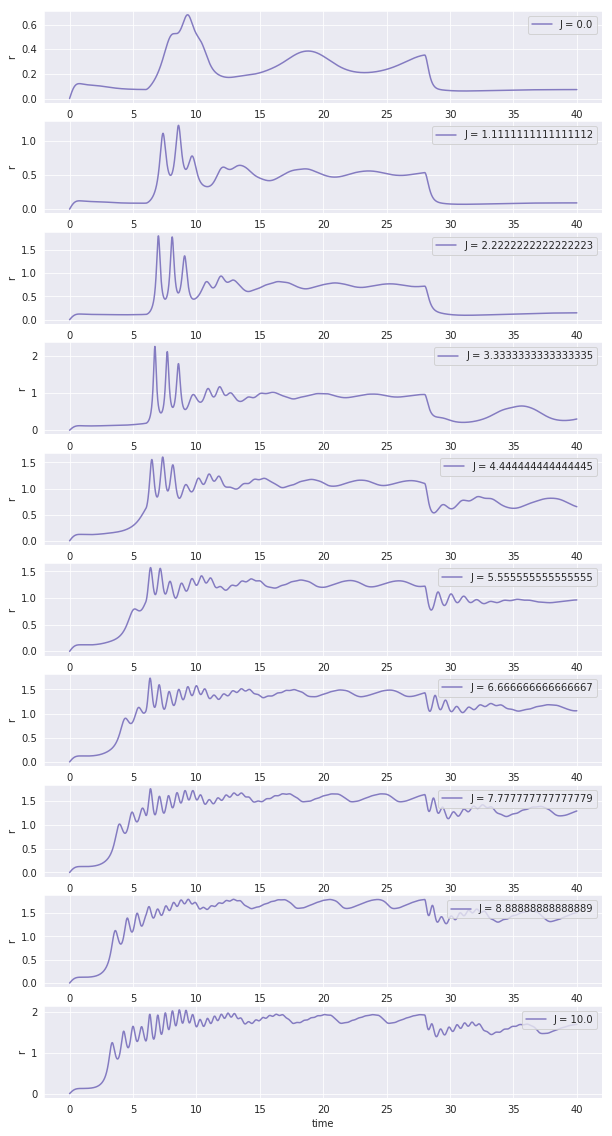

In [10]:
from pyrates.utility import grid_search, create_cmap, plot_timeseries
import matplotlib.pyplot as plt

# definition of parameter sweep values
Js = np.linspace(0, 10, 10)

# other simulation parameters
T = 40.
dt = 1e-2
dts = 1e-2
inp = np.zeros((int(T/dt), 1))
inp[int(6./dt):int((T-12.)/dt)] = 6.

# TODO: implement your solution below
#####################################

# perform a parameter sweep / grid search over all Js using the model from above
results, params = grid_search(circuit_temp, param_grid={'J': Js}, 
                              param_map={'J': {'vars': ['J'],
                                               'nodes': ['PC', 'EIN', 'IIN']}},
                              simulation_time=T, dt=dt, sampling_step_size=dts,
                              inputs={'PC/Op_exc_syn/I_ext': inp},
                              outputs={'r': 'PC/Op_exc_syn/r'},
                              init_kwargs={'vectorization': True, 'solver': 'midpoint'})

# END TODO: Below there is plotting
###################################

fig, axes = plt.subplots(nrows=len(Js), figsize=(10, 20))
cmap = create_cmap('pyrates_purple', as_cmap=False, n_colors=1, reverse=True)
for i, ax in enumerate(axes):
    plot_timeseries(results.iloc[:, i], ax=ax, cmap=cmap, ylabel='r')
    ax.legend([f"J = {params.iloc[i,0]}"], loc='upper right')

#### IV.b parameter sweep over 2 coupling weights

In [11]:
# definition of parameter sweep values
w_ein_pc = np.linspace(0.5, 2.0, 10)*0.8*13.5
w_iin_pc = np.linspace(0.5, 2.0, 10)*1.75*13.5
J = [5.]

# other simulation parameters
T = 100.
dt = 1e-2
dts = 1e-2
inp = np.zeros((int(T/dt), 1)) + 3.

# TODO: implement your solution below
#####################################

# perform a parameter sweep / grid search over all combinations of tau_e and tau_i
results, params = grid_search(circuit_temp, 
                              param_grid={'w_ep': w_ein_pc, 'w_ip': w_iin_pc, 'J': J}, 
                              param_map={'w_ep': {'vars': ['weight'],
                                                  'edges': [('PC', 'EIN')]},
                                         'w_ip': {'vars': ['weight'],
                                                  'edges': [('PC', 'IIN')]},
                                         'J': {'vars': ['J'],
                                               'nodes': ['PC', 'EIN', 'IIN']}},
                              simulation_time=T, dt=dt, sampling_step_size=dts,
                              inputs={'PC/Op_exc_syn/I_ext': inp},
                              outputs={'r': 'PC/Op_exc_syn/r'},
                              init_kwargs={'vectorization': 'nodes', 'solver': 'midpoint'},
                              permute_grid=True)

building the compute graph...
EXPERIMENTAL FEATURE WARNING: Using the midpoint method for solving differential equations is not fully tested yet and should be used with caution.
Preparing the simulation...
Running the simulation...
finished!


When the above cell executed without errors, you can run the two cells below to **(a)** calculate the power-spectral densities of the pyramidal cell firing rate fluctuations for each condition, and **(b)** plot the frequency with the highest power and the respective power in 2D parameter maps.

In [12]:
# NO TODO: Below the power spectral density is extracted
########################################################

from pyrates.utility import fft

# calculate power-spectral density of firing rate fluctuations
max_freq = np.zeros((len(w_ein_pc), len(w_iin_pc)))
max_pow = np.zeros_like(max_freq)
for key in params.index:
    freqs, power = fft(results[key], tmin=20.0)
    idx_c = np.argwhere(w_ein_pc == params.loc[key, 'w_ep'])[0] 
    idx_r = np.argwhere(w_iin_pc == params.loc[key, 'w_ip'])[0]
    max_idx = np.argmax(power)
    max_freq[idx_r, idx_c] = freqs[max_idx]
    max_pow[idx_r, idx_c] = power[max_idx]

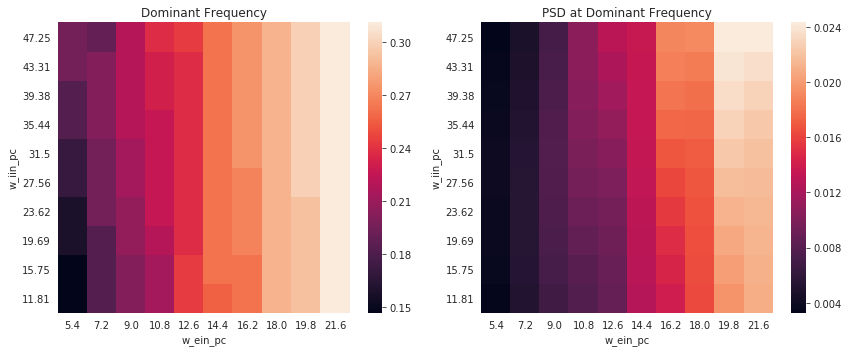

In [13]:
# NO TODO: Below the dominating frequency and its power are plotted
###################################################################

from pyrates.utility import plot_connectivity

# create 2D plots of maximum frequency and PSD for each parameter set
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
plot_connectivity(max_freq, xticklabels=np.round(w_ein_pc, decimals=2), 
                  yticklabels=np.round(w_iin_pc, decimals=2), ax=axes[0])
axes[0].set_xlabel('w_ein_pc')
axes[0].set_ylabel('w_iin_pc')
axes[0].set_title('Dominant Frequency')
plot_connectivity(max_pow.T, xticklabels=np.round(w_ein_pc, decimals=2), 
                  yticklabels=np.round(w_iin_pc, decimals=2), ax=axes[1])
axes[1].set_xlabel('w_ein_pc')
axes[1].set_ylabel('w_iin_pc')
axes[1].set_title('PSD at Dominant Frequency')
plt.tight_layout()

If you want to check the raw timeseries corresponding to each point in the 2D grids, you can use the interactive plotting function provided by pyrates. In the first cell below, the backend of matplotlib is changed to allow for interactive plotting. In the last cell, the interactive plot is created. 

In [15]:
%matplotlib notebook
from pyrates.utility import Interactive2DParamPlot

In [16]:
Interactive2DParamPlot(max_freq, results, w_ein_pc, w_iin_pc, params, tmin=40.0, subplots=plt.subplots(ncols=2, nrows=1, figsize=(12, 5)))

<IPython.core.display.Javascript object>

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices